I noticed that when I used parameter values between [AcceptanceLevel/2, AcceptanceLevel], many of the
parameters didn't have a strong correlation with the goal values or the objective value.
I realized that it was because goal values corresponding to those parameters were already way below the
Acceptance Level, so they never contributed to the optimization. I tried to be clever, and limited
the search ranges for those parameters to be [0, k], where k was the goal result of the default plan.
It turned out that I was able to significantly reduce some of the goal values, but at the expense of
some of the others (e.g., the PTV MaxDose and D2cm MaxDose increased significantly, and the Rib MaxDose also
increased). 

My next attempt will be to only use the objective function terms corresponding to goals that were above a
certain cutoff, maybe 50%. I'll see if this messes up any of the other goals.

In [20]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../../../src')
import analyze
import raybay

In [2]:
# Load treatment plan results
result = np.load('result', allow_pickle=True)

In [6]:
# Reload goal and function dataframes (doesn't save correctly from remote)
result.goal_df = pd.read_csv('../goals.csv') 
result.func_df = pd.read_csv('funcs.csv')
pickle.dump(result, open('result', 'wb'))

In [4]:
# Clinical goals
result.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Bronchus,MaxDvh,AtMost,1560,18.52
1,Bronchus,MaxDose,AtMost,3480,NaN
2,Chestwall_L,MaxDvh,AtMost,3000,2.04
3,D2cm,MaxDose,AtMost,2400,NaN
4,Esophagus,MaxDvh,AtMost,1880,16.91
5,Esophagus,MaxDose,AtMost,3000,NaN
6,GreatVes,MaxDvh,AtMost,4300,5.66
7,GreatVes,MaxDose,AtMost,4900,NaN
8,Heart,MaxDvh,AtMost,2800,1.84
9,Heart,MaxDose,AtMost,3400,NaN


In [7]:
# Constituent functions
result.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Bronchus,MaxDvh,"[0, 952.05]",18.52,NaN,1
1,Bronchus,MaxDose,"[0, 2256.14]",0.00,NaN,1
2,Chestwall_L,MaxDvh,"[0, 2025.76]",2.04,NaN,1
3,D2cm,MaxDose,"[0, 3082.28]",0.00,NaN,1
4,Esophagus,MaxDvh,"[0, 705.37]",16.91,NaN,1
5,Esophagus,MaxDose,"[0, 1180.66]",0.00,NaN,1
6,GreatVes,MaxDvh,"[0, 1177.73]",5.66,NaN,1
7,GreatVes,MaxDose,"[0, 1675.98]",0.00,NaN,1
8,Heart,MaxDvh,"[0, 897.49]",1.84,NaN,1
9,Heart,MaxDose,"[0, 1515.07]",0.00,NaN,1


In [8]:
# Clinical goal results
compare = pd.DataFrame()
for index, row in result.goal_df.iterrows():
    roi = row['Roi']
    goal_type = row['Type']
    level = row['AcceptanceLevel']
    value = result.goal_dict[index][0]
    percent = 100*(value - level)/level
    compare = compare.append({'Roi': roi, 'Type': goal_type, 'AcceptanceLevel': level, 
                              'Result': value, 'PercentChange': percent}, ignore_index=True)
compare = compare[['Roi', 'Type', 'AcceptanceLevel', 'Result', 'PercentChange']] # enforce column order
compare

,Roi,Type,AcceptanceLevel,Result,PercentChange
0,Bronchus,MaxDvh,1560.0,129.328293,-91.709725
1,Bronchus,MaxDose,3480.0,422.652706,-87.854807
2,Chestwall_L,MaxDvh,3000.0,3428.960613,14.298687
3,D2cm,MaxDose,2400.0,5972.372954,148.848873
4,Esophagus,MaxDvh,1880.0,113.335993,-93.971490
5,Esophagus,MaxDose,3000.0,231.755298,-92.274823
6,GreatVes,MaxDvh,4300.0,416.294704,-90.318728
7,GreatVes,MaxDose,4900.0,1234.488578,-74.806356
8,Heart,MaxDvh,2800.0,115.648704,-95.869689
9,Heart,MaxDose,3400.0,243.002636,-92.852864


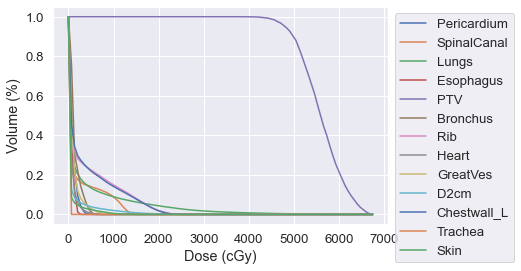

In [9]:
# Dose-volume histograms
result.dvhplot()

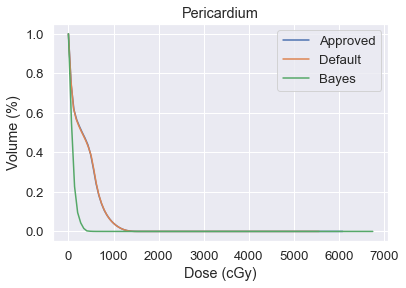

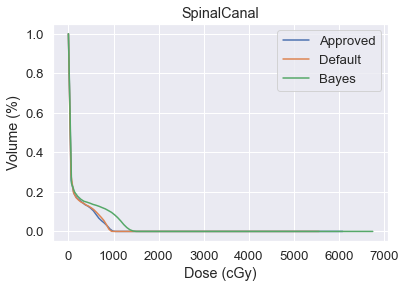

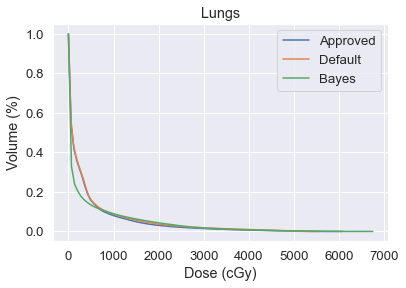

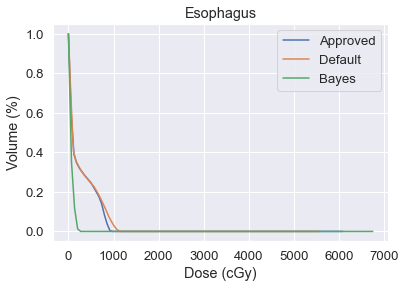

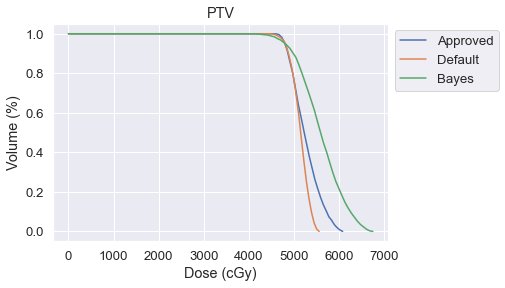

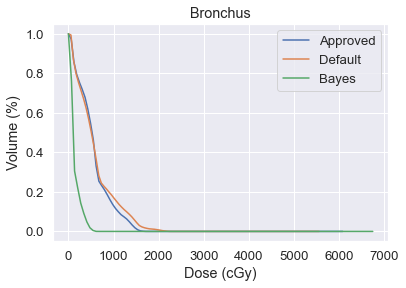

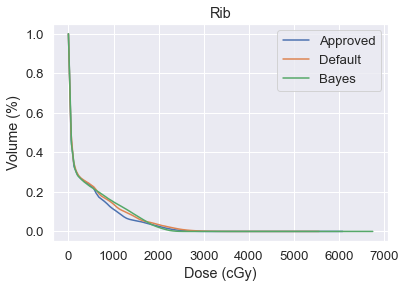

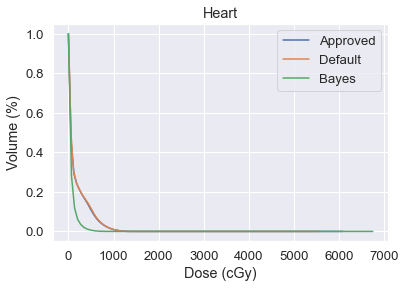

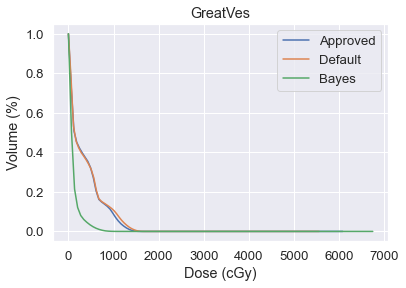

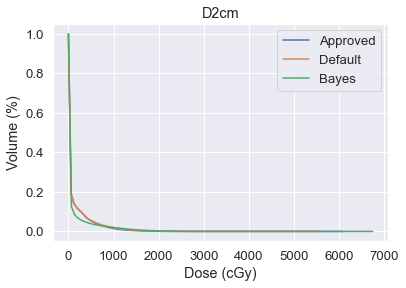

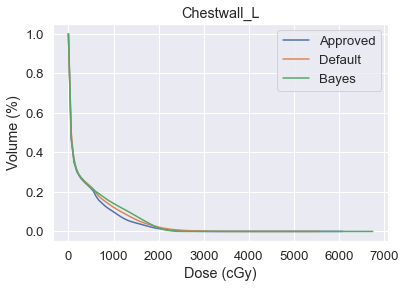

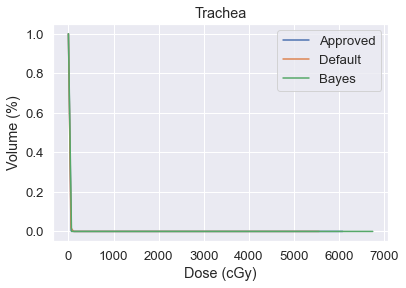

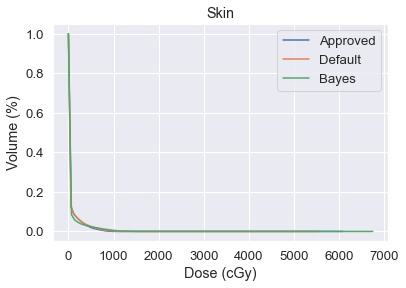

In [11]:
# Compare to other plans
approved = np.load('../approved/result', allow_pickle=True)
default = np.load('../default/result', allow_pickle=True)
for roi in result.roi_list:
    plt.figure()
    plt.plot(approved.dvh_dict['Dose'], approved.dvh_dict[roi])
    plt.plot(default.dvh_dict['Dose'], default.dvh_dict[roi])
    plt.plot(result.dvh_dict['Dose'], result.dvh_dict[roi])
    plt.xlabel('Dose (cGy)')
    plt.ylabel('Volume (%)')
    plt.title(roi)
    plt.legend(['Approved', 'Default', 'Bayes'], bbox_to_anchor=(1, 1))

Text(0, 0.5, 'Objective Value')

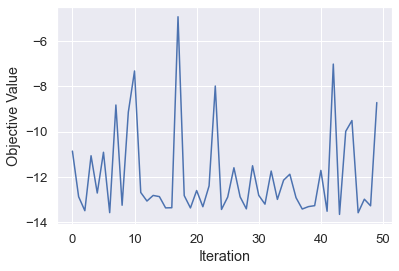

In [13]:
# Convergence of objective
plt.plot(result.opt_result.func_vals)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')

/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


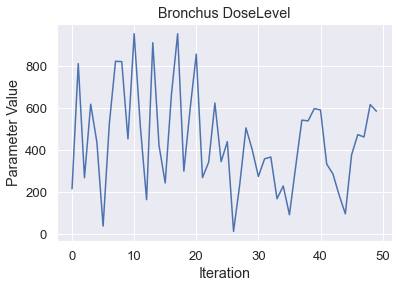

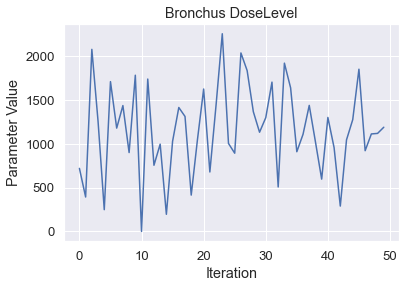

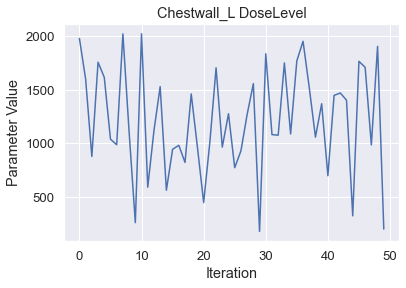

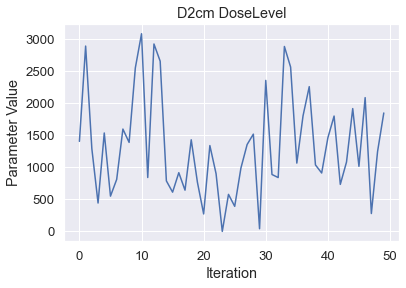

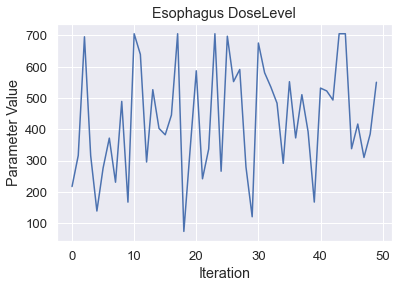

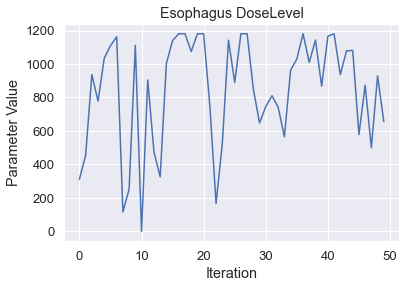

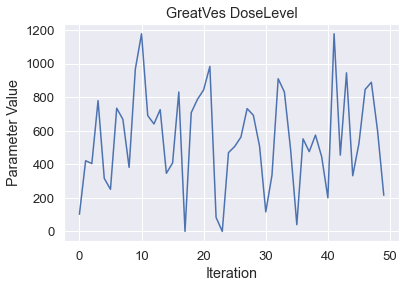

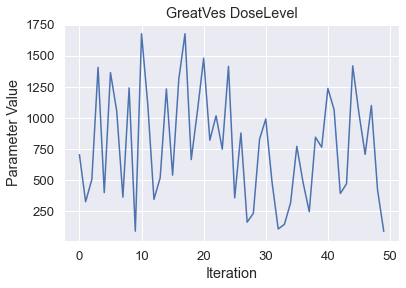

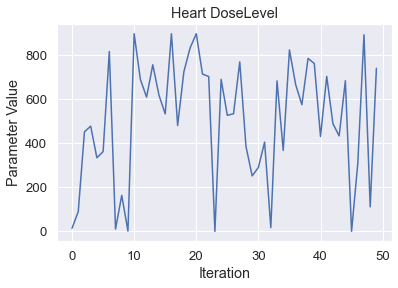

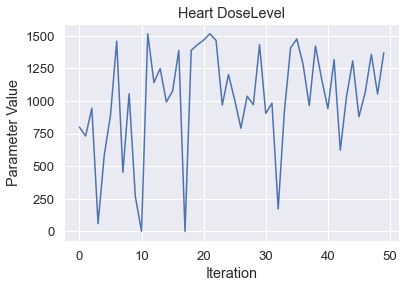

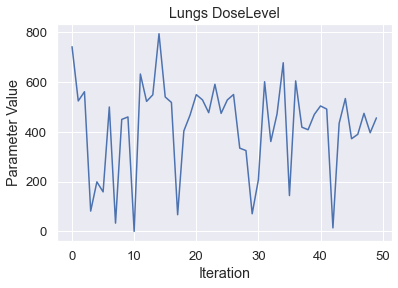

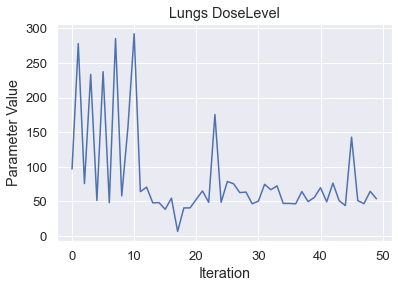

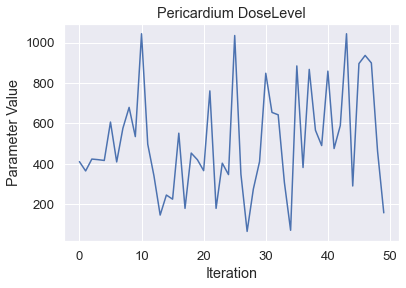

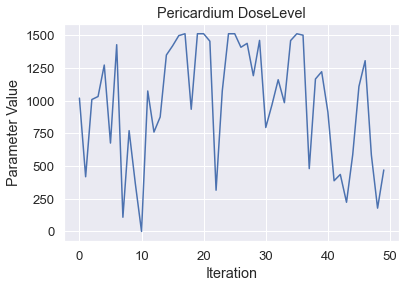

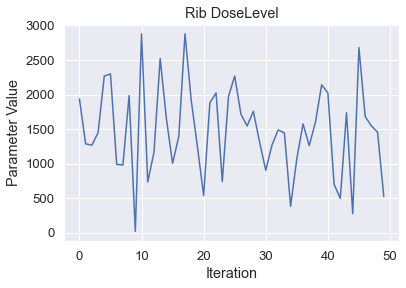

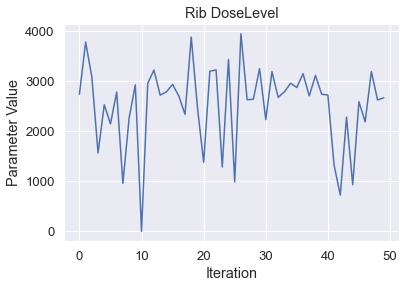

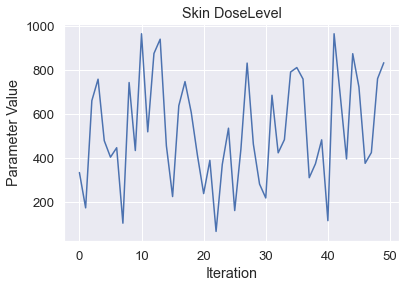

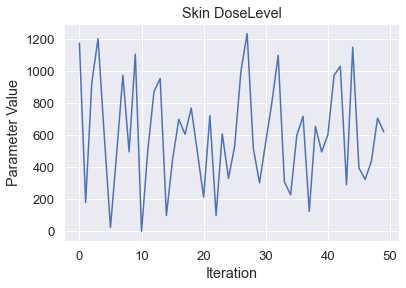

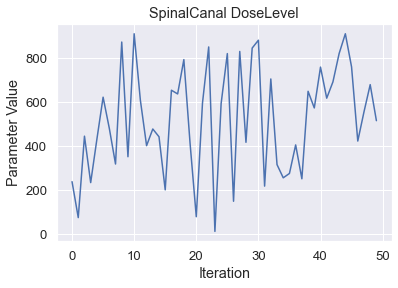

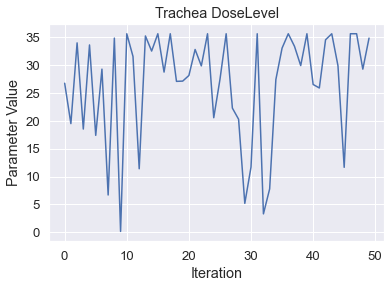

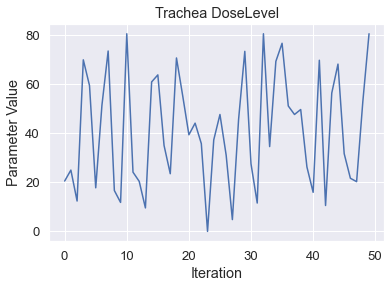

In [24]:
# Convergence of parameters
pars = analyze.get_pars(result.func_df)
x_iters = [[row[ii] for row in result.opt_result.x_iters] for ii in range(21)]
for ii in range(len(x_iters)):
    plt.figure()
    plt.plot(x_iters[ii])
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title(f"{pars.iloc[ii]['Roi']} {pars.iloc[ii]['Par']}")

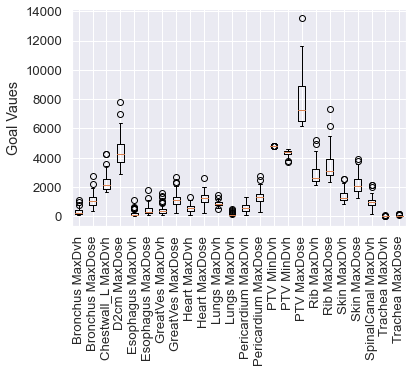

In [31]:
# Distribution of goal values
result.boxplot('goals')

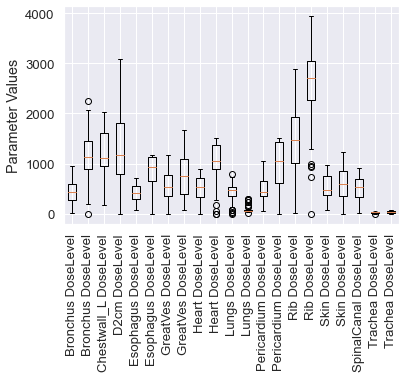

In [27]:
# Distribution of parameter values
result.boxplot('pars')

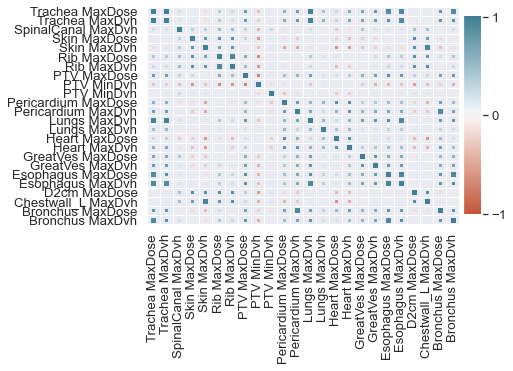

In [29]:
# Correlation between goals values
result.corrplot('goals', size=10)

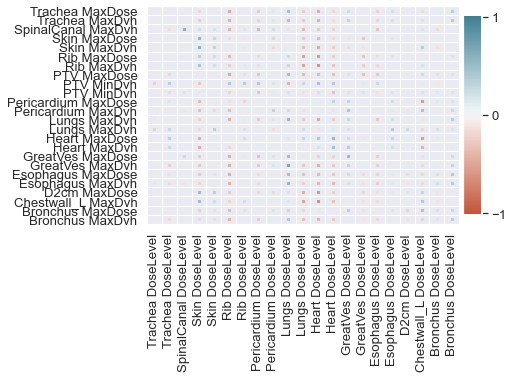

In [30]:
# Correlation between goals and parameters
result.corrplot('pars', size=10)